In [61]:
import os
import json
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re

### Abstract

Revisiting and improving upon prior research is how we advance scientific understanding. We aimed to reproduce the Natural Language Processing (NLP) methods described in Chen et al.(2016) with an updated architecture. This paper explores practical advantages and benchmark accuracy between current transformer NLP methods and legacy neural network-based approaches. To create a controlled comparison, we recreated the original data set using the methods described in the Git repository (Chen, n.d.). We compared those results to modern transformer architecture in NLP with Distilled Bidirectional Encoder Representations from Transformers (DistilBERT), which would improve the accuracy of previous NLP methods. The main challenge is that modern transformer-based NLP has high hardware demands which require workarounds, including dataset limits and infrastructure tradeoffs. However, we achieved a peak accuracy score of 89.44% using DistilBERT while the legacy framework only achieved 23.09% at its peak.

### Key Terms

* **Gated Recurrent Units (GRU)**: Lightweight neural networks that process sequences of words while retaining memory of previous inputs. Efficient and commonly used in earlier NLP systems. (Anishama, 2023)
* **Transformer**: Modern architecture that simultaneously processes the entire input using self-attention, but has higher computational demands. (Aguilera, 2025)
* **Attention**: A mechanism that allows the model to focus on the most essential parts of the context, improving decision-making by weighing its importance. (Winland, 2025)
* **Bidirectional Encoder Representations from Transformers (BERT)**: A deep learning model using transformer-based architecture to understand sentence context by parsing left-to-right and right-to-left.
* **Tokenization**: The process of breaking text into smaller units called tokens. Some models use a fixed token limit, which can force the shortening of long inputs, a process called truncation.

# Introduction

Natural Language Processing is a branch of machine learning focused on enabling computers to understand and interpret human language. Both methods used in this paper rely on a cloze-style question preprocessor, shown in Figure 1. A cloze-style question is a fill-in-the-blank question with one masked word, typically a named entity such as a person, place, or thing. The model must predict the correct answer based on the surrounding context. The two models we use in this paper differ in executing this process. The legacy GRU framework masks the word, constructs the cloze-style question, and ranks possible entity candidates (Anishnama, 2023). The entity marker with the highest score is selected as the predicted answer. The modern transformer framework relies on token-level prediction based on a fixed vocabulary (Aguilera, 2025). It turns the task into a multiple-choice problem based on token likelihoods. The versatility achieved by doing this comes at the cost of significantly higher computational resources.

In [5]:
samples_path = "test.hf.json"
with open(samples_path, "r", encoding="utf-8") as f:
    samples = [json.loads(line) for line in f]
    random.shuffle(samples)
    sample = samples[0]
    question = sample["question"].strip()
    context = sample["context"].strip().split(".")[0] + "."
    label = sample["label"].strip()
    print(f"Question: {question}\nContext: {context}\nLabel: {label}")

Question: celebrity politician and former wrestler @placeholder had posed a question concerning extraterrestrials to a government committee
Context: ( @entity2 ) the classic video game " @entity1 " was developed in @entity3 back in the late 1970 's -- and now their real - life counterparts are the topic of an earnest political discussion in @entity3 's corridors of power .
Label: @entity18


To reduce computational demands, we used a distilled model. Distilled models are smaller models, known as students, that are trained to mimic behavior from a larger teacher model. BERT is trained by masking some words in the text and then using the context in the text to the left and right of the masked word to predict it. DistilBERT is a distillation of BERT, which utilizes the same underlying process but runs on a smaller and more efficient basis. By reducing the number of parameters, DistilBERT can achieve similar goals on less intensive hardware while maintaining comparable levels of accuracy.

Chen et al.(2016) introduced large-scale cloze-style question answering tasks using new *CNN* and *Daily Mail* articles. Each article included bullet point summaries with named entities. The model aims to predict the masked entity by leveraging the article’s context. They implemented a recurrent neural network with GRU and an attention mechanism to help align relevant parts of the article with the questions, which was optimized with computational demand and interoperability. Modern models like BERT and its distillations use transformer architecture, which applies parallel self-attention rather than sequential (Aguilera, 2025). These models are structurally different and have different resource demands. Both models aim to map a cloze-style question using the article context to a predicted entity.

# Methodology

Theano and Lasagne were implemented in the legacy model to reproduce the original architecture by Chen et al.(2016). It could process full-length articles without truncation, requiring minimal processing. This allowed the model to operate on variable-length inputs without the need to filter or constrain articles. Training was conducted using a batch size of 96 on consumer-grade hardware, a Quadro RTX 3000 GPU. Due to modern compatibility issues with Therano and Lasagne, reproducing the model required a virtual Ubuntu machine with a legacy CUDA driver and libraries to ensure compatibility and GPU acceleration. This GRU model was trained from scratch without pretrained embedding or external knowledge, making it a benchmark for evaluating models with minimal dependencies. 

Hugging Face Transformers and Pytorch were our baseline for the modern model architecture. We selected distilbert-base-unccased as the pretrained model architecture, and set floating-point-16 precision to reduce memory usage. The preprocessing pipeline truncated each article around the answer and filtered out samples with fewer than four entities present. To prevent token overflow, we used an approximation of final token counts. These adjustments excluded over 70% of the data due to token length constraints or a lack of entities. Even with this significant data loss, the retained samples still reflected messy data of real-world environments, as seen in Figure 2. DistilBert was trained on an A100 GPU through Google Colab Pro using a batch size of 1 and no gradient accumulation. The model was evaluated on a separate development subset after each epoch.

Both models were trained using hyperparameters over three epochs to maintain fairness. Evaluation relied on accuracy to focus on answer correctness and aligned with the outputs of the legacy implementation. Both models' data sets were constructed using Google DeepMind's question story files from the NYU Archive (Cho, n.d.). The original train/dev/test splits were preserved. By stratified random sampling, 80,000 training samples were selected from *CNN* and *Daily Mail* articles to maintain article diversity and reduce computational constraints on the transformer architecture.

In [26]:
distribution_of_variation_df = pd.read_csv("entity_filtering_summary.csv")
distribution_of_variation_df.drop(["Raw Count", "Raw Min", "Filtered Min", "Filtered Max", "Filtered Mean",
                                   "Filtered Median", "Reduction (Mean)", "% Reduction (Mean)"], axis=1, inplace=True)
print(distribution_of_variation_df)

     Dataset       Split  Filtered Count  Raw Max  Raw Mean  Raw Median
0        CNN       Train           25256      527     26.39        23.0
1        CNN  Validation            1376      187     26.19        22.0
2        CNN        Test            1007      394     24.22        21.0
3  DailyMail       Train           16019      329     26.25        22.0
4  DailyMail  Validation           16424      230     25.02        21.0
5  DailyMail        Test           12731      245     25.48        21.0


# Results

During the training, there was a clear divide in each model's convergence characteristics. DistilBERT showed a rapid improvement in accuracy within the first thousand steps and increased over the subsequent epochs. This is expected, as the model had an advantage from extensive pretraining on the general domain. The GRU reached an early plateau, showing limited gains after epoch one, even with stable behavior during training. Training loss mirrored this trend, as DistilBERT consistently reduced training loss over time while the GRU model stabilized at a higher loss. DistilBERT’s pretrained initialization provided a significant head start, where the GRU architecture training from scratch was limited by the limited cloze-style data it was provided, see figures 3 and 4 for final accuracy, training time, and hardware differences.

In [32]:
modern_cnn_results = pd.read_csv("model results/cnn_training.csv")
modern_cnn_results = modern_cnn_results.dropna()
modern_cnn_results["Dataset"] = "CNN"

modern_daily_mail_results = pd.read_csv("model results/dailymail_training_log.csv")
modern_daily_mail_results = modern_daily_mail_results.dropna()
modern_daily_mail_results["Dataset"] = "Daily Mail"

modern_merge = pd.concat([modern_cnn_results, modern_daily_mail_results])

In [125]:
def parse_legacy_logs(log_path):
    # Load the log file
    with open(log_path, "r") as file:
        log_data = file.readlines()

    # Define regex patterns
    loss_pattern = re.compile(r"iter = (\d+).*?loss = ([\d.]+)")
    accuracy_pattern = re.compile(r"Dev accuracy: ([\d.]+) %")

    # Extract loss per step
    '''loss_records = []
    for line in log_data:
        match = loss_pattern.search(line)
        if match:
            step = int(match.group(1))
            loss = float(match.group(2))
            loss_records.append({"iter": step, "loss": loss, "accuracy": None})'''

    # Extract accuracy (evaluated every 500 steps)
    step_interval = 500
    accuracy_records = []
    for i, line in enumerate(log_data):
        match = accuracy_pattern.search(line)
        if match:
            accuracy = float(match.group(1))
            step = step_interval * len(accuracy_records)
            accuracy_records.append({"iter": step, "accuracy": accuracy})

    # Merge into single DataFrame
    #loss_df = pd.DataFrame(loss_records).set_index("iter")
    accuracy_df = pd.DataFrame(accuracy_records).set_index("iter")
    #return loss_df.join(accuracy_df, how="left", lsuffix='_loss', rsuffix='_acc').drop(["accuracy_loss"], axis=1).dropna(how="any").reset_index()
    return accuracy_df.dropna(how="any").reset_index()

In [135]:
legacy_cnn_results = parse_legacy_logs("model results/cnn_train_80k_b96_e3_strat_v4.log")
legacy_cnn_results["Dataset"] = "CNN"
legacy_cnn_results["iter"] = [x * 500 for x in range(legacy_cnn_results["iter"].count())]

legacy_daily_mail_results = parse_legacy_logs("model results/dm_train_80k_b96_e3_strat_v1.log")
legacy_daily_mail_results["Dataset"] = "Daily Mail"
legacy_daily_mail_results["iter"] = [x * 500 for x in range(legacy_daily_mail_results["iter"].count())]

legacy_merge = pd.concat([legacy_cnn_results, legacy_daily_mail_results])

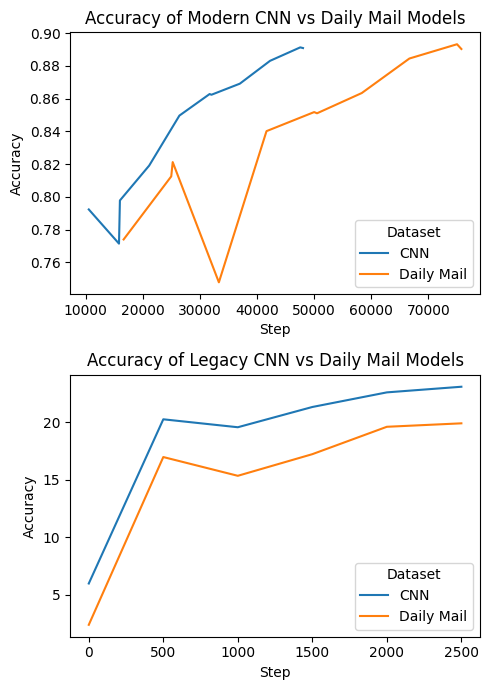

In [138]:
fig, ax = plt.subplots(2, 1, figsize=(5, 7));
sns.lineplot(ax=ax[0], x="Step", y="Accuracy", hue="Dataset", data=modern_merge);
ax[0].set_title("Accuracy of Modern CNN vs Daily Mail Models");
sns.lineplot(ax=ax[1], x="iter", y="accuracy", hue="Dataset", data=legacy_merge);
ax[1].set_title("Accuracy of Legacy CNN vs Daily Mail Models");
ax[1].set_xlabel("Step");
ax[1].set_ylabel("Accuracy");
plt.tight_layout();

In [8]:
headers = ["Model", "Dataset", "Best Accuracy", "Training Time", "Notes"]
rows = [
    ["GRU", "CNN", "23.09%", "5h 21m", "Full context, consumer GPU"],
    ["GRU", "Daily Mail", "19.91%", "10h 24m", "Full context, consumer GPU"],
    ["DistilBERT", "CNN", "89.44%", "4h 11m", "Truncated input, A100 GPU"],
    ["DistilBERT", "Daily Mail", "86.79%", "1h 51m", "Truncated input, A100 GPU"]
]

print(pd.DataFrame(rows, columns=headers))

        Model     Dataset Best Accuracy Training Time  \
0         GRU         CNN        23.09%        5h 21m   
1         GRU  Daily Mail        19.91%       10h 24m   
2  DistilBERT         CNN        89.44%        4h 11m   
3  DistilBERT  Daily Mail        86.79%        1h 51m   

                        Notes  
0  Full context, consumer GPU  
1  Full context, consumer GPU  
2   Truncated input, A100 GPU  
3   Truncated input, A100 GPU  


Superior performance was achieved with DistilBERT in both datasets, but it came at significant tradeoffs. This model required high-end hardware, aggressive preprocessing, and exclusion of most of the dataset to meet memory constraints. While the GRU model ran entirely on consumer-grade hardware, it had minimal processing and could use full-length article context. The GRU model was less accurate, but its ability to be used and its interpretability make it a consideration with limited resources or technical requirements

# Conclusion

This exploration shows one of the central debates in NLP: the newest model isn’t always the right tool. DistilBERT’s performance is four times greater than the GRU model's, but this comes at the cost of extensive infrastructure, massive data pruning, and reliance on pre-trained language, showing the power and limitations of modern transformer-based architecture. Still, it shows the growing barrier for anyone without access to high-end computing. Despite being made nine years ago, the GRU model has proven capable of handling long-form input and offering relative ease of deployment. It is compatible with unfitted full article text while operating in resource-constrained environments. These traits, simplicity, transparency, and compatibility, offer meaningful advantages for resource-limited settings. These often get lost due to the ever-increasing need for benchmark improvements.  Ultimately, these tools are only as good as the context in which they are used. Data scientists must understand when and why to use them, choosing tools that align with the problem, its constraints, and intended impact. Revisiting older models isn't for nostalgia. It's about expanding our perspective and re-evaluating which solution meets our goals. As NLP continues to evolve, looking back can still show us paths forward.

# <p style="text-align: center;">References</p>

Chen, D., Bolton, J., & Manning, C. D. (2016). A thorough examination of the CNN/Daily Mail Reading Comprehension Task. *Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)*. https://doi.org/10.18653/v1/p16-1223

Chen, D. (n.d.). *Danqi/RC-CNN-dailymail: CNN/Daily Mail Reading Comprehension task*. GitHub. https://github.com/danqi/rc-cnn-dailymail

Aguilera, F. M. (2025, April 18). *Transformer-based multiple choice question answering: Implementation, output analysis, and bias...* Medium. https://medium.com/ai-simplified-in-plain-english/transformer-based-multiple-choice-question-answering-implementation-output-analysis-and-bias-e04d3d6d9c03

Winland, V. (2025, March 11). *What is self-attention?*. IBM. https://www.ibm.com/think/topics/self-attention

Anishnama. (2023, May 4). *Understanding gated recurrent unit (GRU) in deep learning*. Medium. https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

Cho, K. (n.d.). *DeepMind Q&A Dataset*. DMQA. https://cs.nyu.edu/~kcho/DMQA/ 